# Plots

The purpose of this notebook is to combine and compare the results of grid search, random search, and Bayesian hyperparameter optimization ("Bayesian search" or "Bayes search") on the five model types evaluated (KNN, decision tree, random forest, fully connected network, CNN).

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/CS682_Clean')

In [3]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 4.3MB/s 


In [4]:
import os, sys
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin  # so we can make a custom classifier

import skopt
from skopt import BayesSearchCV
from skopt.space.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, TimerCallback

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import TensorDataset
from torch.utils.data import RandomSampler

In [5]:
from nn_classifiers import _custom_scorer, FCNet, FCNetClassifier, CNN, CNNClassifier

In [6]:
# from https://stackoverflow.com/a/53211409, this is a way to make sure the axes are sorted properly by 
# plotting the sorted data, then removing it, thereby setting the axes first
def unitsetter(xunits, yunits, ax=None, sort=True):
    ax = ax or plt.gca()
    if sort:
        xunits = sorted(xunits)
        yunits = sorted(yunits)
    us = plt.plot(xunits, [yunits[0]]*len(xunits),
                  [xunits[0]]*len(yunits), yunits)
    for u in us:
        u.remove()

In [25]:
def plot_parameters(results, model_type, search_type, hyperparameters):
    if search_type != 'bayes':
        accs = np.array([x['mean_metric'] for x in results])
        best_model = sorted(results, key=lambda x: -x['mean_metric'])[0]

        if search_type == 'grid':
            label = 'Grid Search'
        elif search_type == 'random':
            label = 'Random Search'
    else:
        if type(results) == BayesSearchCV:
            results = results.cv_results_

        accs = np.array(results['mean_test_score'])
        bs_results = [{'params': dict(x[0]), 'mean_metric': x[1]} for x in list(zip(results['params'], accs))]
        best_model = sorted(bs_results, key=lambda x: -x['mean_metric'])[0]

        label = 'Bayesian Search'

    cumul_accs = np.maximum.accumulate(accs)
    errs = 1 - accs
    cumul_errs = 1 - cumul_accs

    params = hyperparameters.keys()
    fig = plt.figure(figsize=(12, 4*len(params)), dpi=75)

    for i, param in enumerate(params):
        plt.subplot(len(params), 2, 2*i+1)
        
        if search_type != 'bayes':
            param_vals = [x['params'][param] for x in results]
        else:
            param_vals = results[f'param_{param}']

        if type(param_vals[0]) == bool:
            param_vals = [str(x) for x in param_vals]

        best_val = best_model['params'][param]

        unitsetter(np.arange(1,len(param_vals)+1), param_vals)
        plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
        plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
        plt.xlim(1, len(param_vals))
        if param in ['learning_rate', 'weight_decay']:
            plt.yscale('log')
        plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

        plt.ylabel(param, fontsize=14)
        plt.xlabel("iteration", fontsize=14)
        cb = plt.colorbar()
        cb.set_label("accuracy")
        plt.tick_params(labelsize=14)

        param_vals = sorted(param_vals)
        plt.subplot(len(params), 2, 2*i+2)
        if param not in ['learning_rate', 'weight_decay']:
            plt.hist(param_vals, bins=30)
        else:
            hist, bins = np.histogram(param_vals, bins=30)
            logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
            plt.hist(param_vals, bins=logbins)
            plt.xscale('log')
        plt.axvline(x=best_val, color='red', linestyle='--')
        plt.xlabel(param, fontsize=14)
        plt.ylabel('# of evaluations', fontsize=14)
        plt.tick_params(labelsize=14)

    
    plt.tight_layout(rect=[0, 0.0, 1, 0.98])
    plt.suptitle(f"{model_type} - {label}\nHyperparameter Evaluations", size=16, verticalalignment='bottom')

# Load Data

## Grid Search

In [8]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
knn_gs_hyperparameters = {
    'n_neighbors': range(2, 40, 6),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

with open('results/knn_gs_results_201212_190705.pkl', 'rb') as f:
    knn_gs_results = pickle.load(f)
knn_gs = knn_gs_results['gs']
knn_gs_results = knn_gs_results['gs_results']

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
decisiontree_gs_hyperparameters = {
    'max_depth': [25, 50, 100, 500, 2000], 
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': range(2, 45, 7),  # 7
    'min_samples_leaf': range(1, 100, 15),  # 7
}

with open('results/decisiontree_gs_results_201206_210847.pkl', 'rb') as f:
    decisiontree_gs_results = pickle.load(f)
decisiontree_gs = decisiontree_gs_results['gs']
decisiontree_gs_results = decisiontree_gs_results['gs_results']

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
randomforest_gs_hyperparameters = {
    'max_depth': [25, 100, 2000],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 20],
    'min_samples_leaf': [1, 50],
    'n_estimators': [50, 150, 300, 500],
    'bootstrap': [True, False]
}

with open('results/randomforest_gs_results_201206_024917.pkl', 'rb') as f:
    randomforest_gs_results = pickle.load(f)
randomforest_gs = randomforest_gs_results['gs']
randomforest_gs_results = randomforest_gs_results['gs_results']

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
# N_EVALS = 576
fcnet_gs_hyperparameters = {
    'num_layers': [3, 2, 1],
    'hidden_size': [4000, 2000, 1000, 500],
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0],  # 0 = same as no dropout
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],
    'weight_decay': [1e-5, 1e-3, 1e-2]
}

with open('results/fcnet_gs_results_20201213_151504.pkl', 'rb') as f:
    fcnet_gs_results = pickle.load(f)

In [12]:
# N_EVALS = 648
cnn_gs_hyperparameters = {
    'filter_size': [1, 3, 5],  # 1, 3, 5 
    'n_filters': [16, 64, 128], 
    'stride': [1, 3],
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0.25, 0.0],  # 0 = same as no dropout
    'learning_rate': [1e-5, 1e-4, 1e-1],
    'weight_decay': [1e-5, 1e-3]
}

with open('results/cnn_gs_results_20201213_190229.pkl', 'rb') as f:
    cnn_gs_results = pickle.load(f)

## Random Search

In [13]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
knn_rs_hyperparameters = {
    'n_neighbors': range(2, 40),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

with open('results/knn_rs_results_201212_233621.pkl', 'rb') as f:
    knn_rs_results = pickle.load(f)
knn_rs = knn_rs_results['rs']
knn_rs_results = knn_rs_results['rs_results']

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
decisiontree_rs_hyperparameters = {
    'max_depth': range(25, 2001),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': range(2, 45),
    'min_samples_leaf': range(1, 100)
}

with open('results/decisiontree_rs_results_201206_213128.pkl', 'rb') as f:
    decisiontree_rs_results = pickle.load(f)
decisiontree_rs = decisiontree_rs_results['rs']
decisiontree_rs_results = decisiontree_rs_results['rs_results']

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
randomforest_rs_hyperparameters = {
    'max_depth': range(1, 2001),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': range(2, 45),
    'min_samples_leaf': range(1, 100),
    'n_estimators': range(25, 500),
    'bootstrap': [True, False]
}

with open('results/randomforest_rs_results_201206_070311.pkl', 'rb') as f:
    randomforest_rs_results = pickle.load(f)
randomforest_rs = randomforest_rs_results['rs']
randomforest_rs_results = randomforest_rs_results['rs_results']

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
# N_EVALS = 576
fcnet_rs_hyperparameters = {
    'num_layers': range(1, 3+1),
    'hidden_size': range(500, 4001, 250),
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0.25, 0.0],  # 0 = same as no dropout
     'learning_rate': list(np.logspace(-6, -2, num=20)),
    'weight_decay': list(np.logspace(-5, -2, num=10))
}

with open('results/fcnet_rs_results_20201213_163356.pkl', 'rb') as f:
    fcnet_rs_results = pickle.load(f)

In [17]:
# N_EVALS = 648
cnn_rs_hyperparameters = {
    'filter_size': [1, 3, 5],  # 1, 3, 5 
    'n_filters': [16, 32, 64, 128], 
    'stride': [1, 3],
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0.25, 0.0],  # 0 = same as no dropout
    'learning_rate': list(np.logspace(-6, -1, num=20)),
    'weight_decay': list(np.logspace(-5, -2, num=10))
}

with open('results/cnn_rs_results_20201213_233541.pkl', 'rb') as f:
    cnn_rs_results = pickle.load(f)

## Bayesian Search

In [18]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
knn_bayes_hyperparameters = {
    'n_neighbors': Integer(2, 40),
    'weights': Categorical(['uniform', 'distance']),
    'p': Integer(1, 2)
}

knn_bayes_results = skopt.load('results/knn_bayes_result_20201213_133739.pkl')

with open('results/knn_bayes_timercb_20201213_133739.pkl', 'rb') as f:
    knn_timercb = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
decisiontree_bayes_hyperparameters = {
    'max_depth': Integer(25, 2000),  # bounds are *inclusive*
    'max_features': Categorical(['sqrt', 'log2']),
    'min_samples_split': Integer(2, 45),
    'min_samples_leaf': Integer(1, 100)
}

decisiontree_bayes_results = skopt.load('results/decisiontree_bayes_result_20201213_091811.pkl')

with open('results/decisiontree_bayes_timercb_20201213_091811.pkl', 'rb') as f:
    decisiontree_timercb = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
# NOTE: ONLY FOUR CLASSES USED 0 (airplane), 2 (bird), 7 (horse), 8 (ship)
randomforest_bayes_hyperparameters = {
    'max_depth': Integer(1, 2001),
    'max_features': Categorical(['sqrt', 'log2']),
    'min_samples_split': Integer(2, 45),
    'min_samples_leaf': Integer(1, 100),
    'n_estimators': Integer(25, 500),
    'bootstrap': Categorical([True, False])
}

randomforest_bayes_results = skopt.load('results/randomforest_bayes_result_20201214_072555.pkl')

with open('results/randomforest_bayes_timercb_20201214_072555.pkl', 'rb') as f:
    randomforest_timercb = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
# N_EVALS = 576
fcnet_bayes_hyperparameters = {
     'num_layers': Integer(1, 3), 
     'hidden_size': Integer(500, 4000), 
     'leaky_relu': Categorical([False, True]),
     'p_dropout': Categorical([0.5, 0.25, 0.0]),  # 0 = same as no dropout
     'learning_rate': Real(1e-6, 1e-2, prior='log-uniform'), 
     'weight_decay': Real(1e-5, 1e-2, prior='log-uniform')
}

fcnet_bayes_results = skopt.load('results/fcnet_bayes_result_20201214_015733.pkl')

with open('results/fcnet_bayes_timercb_20201214_015733.pkl', 'rb') as f:
    fcnet_timercb = pickle.load(f)

In [22]:
# N_EVALS = 648
cnn_bayes_hyperparameters = {
     'filter_size': Categorical([1, 3, 5]),  # 1, 3, 5 
     'n_filters': Categorical([16, 32, 64, 128]), 
     'stride': Categorical([1, 3]),
     'leaky_relu': Categorical([False, True]),
     'p_dropout': Real(0.0, 0.50), 
     'learning_rate': Real(1e-6, 1e-1, prior='log-uniform'), 
     'weight_decay': Real(1e-5, 1e-2, prior='log-uniform')
}

cnn_bayes_results = skopt.load('results/cnn_bayes_result_20201215_081010.pkl')

with open('results/cnn_bayes_timercb_20201215_081010.pkl', 'rb') as f:
    cnn_timercb = pickle.load(f)

# Hyperparameter Plots

In [26]:
plt.close('all')
for results, model_type, search_type, hyperparameters in [(knn_gs_results, 'KNN', 'grid', knn_gs_hyperparameters), 
                                                          (knn_rs_results, 'KNN', 'random', knn_rs_hyperparameters),
                                                          (knn_bayes_results, 'KNN', 'bayes', knn_bayes_hyperparameters), 

                                                          (decisiontree_gs_results, 'Decision Tree', 'grid', decisiontree_gs_hyperparameters), 
                                                          (decisiontree_rs_results, 'Decision Tree', 'random', decisiontree_rs_hyperparameters),
                                                          (decisiontree_bayes_results, 'Decision Tree', 'bayes', decisiontree_bayes_hyperparameters), 

                                                          (randomforest_gs_results, 'Random Forest', 'grid', randomforest_gs_hyperparameters), 
                                                          (randomforest_rs_results, 'Random Forest', 'random', randomforest_rs_hyperparameters),
                                                          (randomforest_bayes_results, 'Random Forest', 'bayes', randomforest_bayes_hyperparameters), 

                                                          (fcnet_gs_results, 'FC Network', 'grid', fcnet_gs_hyperparameters), 
                                                          (fcnet_rs_results, 'FC Network', 'random', fcnet_rs_hyperparameters),
                                                          (fcnet_bayes_results, 'FC Network', 'bayes', fcnet_bayes_hyperparameters), 

                                                          (cnn_gs_results, 'CNN', 'grid', cnn_gs_hyperparameters), 
                                                          (cnn_rs_results, 'CNN', 'random', cnn_rs_hyperparameters),
                                                          (cnn_bayes_results, 'CNN', 'bayes', cnn_bayes_hyperparameters), 
]:
    plot_parameters(results, model_type, search_type, hyperparameters)

Output hidden; open in https://colab.research.google.com to view.

# Combined Convergence Plot

In [65]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

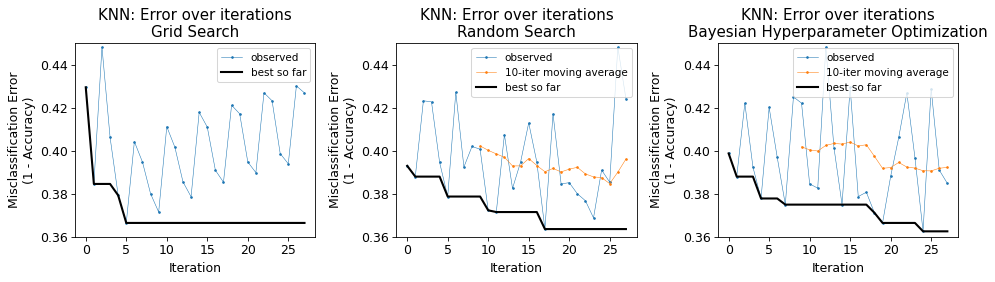

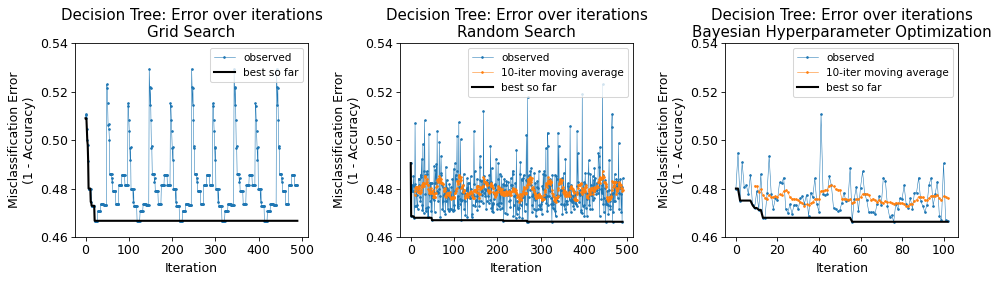

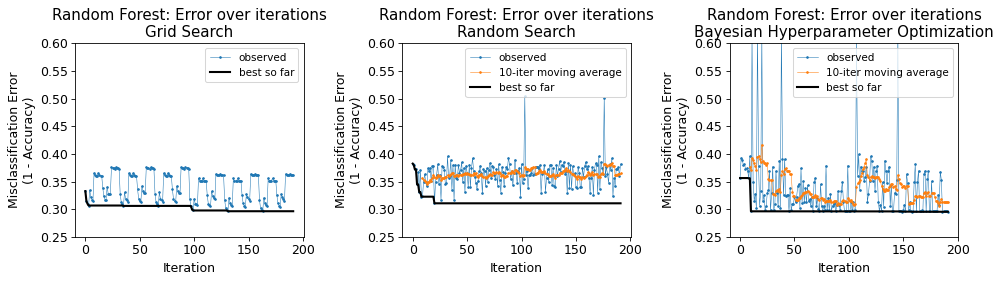

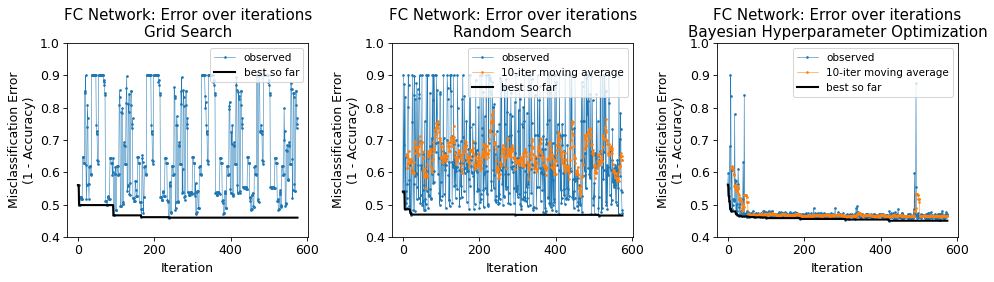

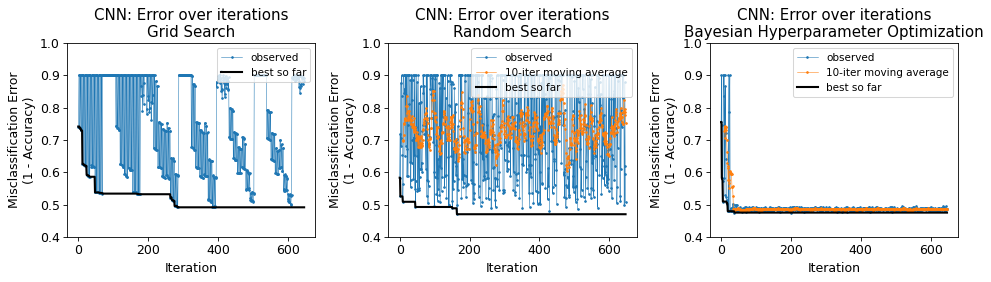

In [74]:
# NOTE: Bayesian search for decision tree stopped early due to early stopping criterion (top 5 results within 0.001 of the best)
plt.close('all')

for gs_results, rs_results, bayes_result, ylim, label in [(knn_gs_results, knn_rs_results, knn_bayes_results, (0.36, 0.45), 'KNN'),
                                                          (decisiontree_gs_results, decisiontree_rs_results, decisiontree_bayes_results, (0.46, 0.54), 'Decision Tree'),
                                                          (randomforest_gs_results, randomforest_rs_results, randomforest_bayes_results, (0.25, 0.6), 'Random Forest'),
                                                          (fcnet_gs_results, fcnet_rs_results, fcnet_bayes_results, (0.4, 1), 'FC Network'),
                                                          (cnn_gs_results, cnn_rs_results, cnn_bayes_results, (0.4, 1), 'CNN')]:
    if type(bayes_result) == BayesSearchCV:
        bayes_result = bayes_result.cv_results_

    plt.figure(figsize=(14, 4), dpi=75)
    plt.rc('font', size=12)

    ####### convergence plot, GS
    plt.subplot(1, 3, 1)

    accs = np.array([x['mean_metric'] for x in gs_results])
    cumul_accs = np.maximum.accumulate(accs)
    errs = 1-accs
    cumul_errs = 1-cumul_accs
    plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
    plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
    plt.xlabel("Iteration")
    plt.ylabel("Misclassification Error\n(1 - Accuracy)")
    plt.title(f"{label}: Error over iterations\nGrid Search")
    plt.legend(loc='upper right', fontsize='small')
    plt.ylim(ylim)


    ####### convergence plot, RS
    plt.subplot(1, 3, 2)

    accs = np.array([x['mean_metric'] for x in rs_results])
    cumul_accs = np.maximum.accumulate(accs)
    errs = 1-accs
    cumul_errs = 1-cumul_accs

    WINDOW_SIZE = 10
    move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
    move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

    plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
    plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
    plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
    plt.xlabel("Iteration")
    plt.ylabel("Misclassification Error\n(1 - Accuracy)")
    plt.title(f"{label}: Error over iterations\nRandom Search")
    plt.legend(loc='upper right', fontsize='small')
    plt.ylim(ylim)


    ####### convergence plot, Bayesian
    plt.subplot(1, 3, 3)

    accs = np.array(bayes_result['mean_test_score'])
    cumul_accs = np.maximum.accumulate(accs)
    errs = 1-accs
    cumul_errs = 1-cumul_accs

    WINDOW_SIZE = 10
    move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
    move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

    plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
    plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
    plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
    plt.xlabel("Iteration")
    plt.ylabel("Misclassification Error\n(1 - Accuracy)")
    plt.title(f"{label}: Error over iterations\nBayesian Hyperparameter Optimization")
    plt.legend(loc='upper right', fontsize='small')
    plt.ylim(ylim)


    plt.tight_layout(rect=[0, 0.0, .96, 0.98])

# Calculate iterations to near-best

Defined as within 0.001 of best accuracy

In [84]:
# calculate number of iterations until "near-best" accuracy, defined as within 0.001 of best accuracy

ACC_WINDOW = 0.001
summary = []

for results, model_type, search_type, timercb in [(knn_gs_results, 'KNN', 'Grid', None),
                                                  (knn_rs_results, 'KNN', 'Random', None),
                                                  (knn_bayes_results, 'KNN', 'Bayes', knn_timercb),

                                                  (decisiontree_gs_results, 'Decision Tree', 'Grid', None),
                                                  (decisiontree_rs_results, 'Decision Tree', 'Random', None),
                                                  (decisiontree_bayes_results, 'Decision Tree', 'Bayes', decisiontree_timercb),

                                                  (randomforest_gs_results, 'Random Forest', 'Grid', None),
                                                  (randomforest_rs_results, 'Random Forest', 'Random', None),
                                                  (randomforest_bayes_results, 'Random Forest', 'Bayes', randomforest_timercb),

                                                  (fcnet_gs_results, 'FC Net', 'Grid', None),
                                                  (fcnet_rs_results, 'FC Net', 'Random', None),
                                                  (fcnet_bayes_results, 'FC Net', 'Bayes', fcnet_timercb),

                                                  (cnn_gs_results, 'CNN', 'Grid', None),
                                                  (cnn_rs_results, 'CNN', 'Random', None),
                                                  (cnn_bayes_results, 'CNN', 'Bayes', cnn_timercb)
                                                 ]:

    if type(results) == BayesSearchCV:
        results = results.cv_results_

    if search_type == 'Bayes':
        accs = np.array(results['mean_test_score'])
        
        if timercb is not None:
            times = np.array(timercb.iter_time)
    else:
        accs = np.array([x['mean_metric'] for x in results])
        times = np.array([x['mean_fit_time'] + x['mean_score_time'] for x in results])
    
    cumul_accs = np.maximum.accumulate(accs)
    cumul_times = np.cumsum(times)

    nearbest_iter = np.argmax(np.round(cumul_accs - cumul_accs[-1], 6) >= -ACC_WINDOW)
    nearbest_acc = cumul_accs[nearbest_iter]
    nearbest_time = cumul_times[nearbest_iter]
    summary.append({'model_type': model_type, 
                    'search_type': search_type, 
                    'total_iters': len(accs),
                    'true_best': cumul_accs[-1],
                    'nearbest_iter': nearbest_iter, 
                    'nearbest_time': nearbest_time, 
                    'nearbest_acc': nearbest_acc, 
                    })

summary = pd.DataFrame(summary)
summary

,model_type,search_type,total_iters,true_best,nearbest_iter,nearbest_time,nearbest_acc
0,KNN,Grid,28,0.63345,5,693.089139,0.63345
1,KNN,Random,28,0.63630,17,2076.924879,0.63630
2,KNN,Bayes,28,0.63735,24,14854.949745,0.63735
3,Decision Tree,Grid,490,0.53330,21,18.113022,0.53330
4,Decision Tree,Random,490,0.53370,49,25.885073,0.53305
5,Decision Tree,Bayes,103,0.53370,56,437.349756,0.53370
6,Random Forest,Grid,192,0.70340,131,2413.070890,0.70340
7,Random Forest,Random,192,0.68910,20,491.313894,0.68910
8,Random Forest,Bayes,192,0.70440,10,1316.107610,0.70355
9,FC Net,Grid,576,0.54000,238,2447.185973,0.54000


In [85]:
summary.to_csv('results/summary_complexity_runtime.csv', index=False)

# Bayesian Runtime Plot

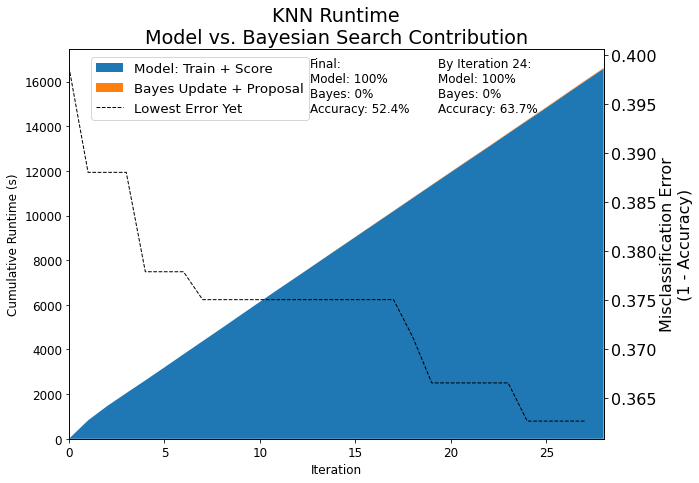

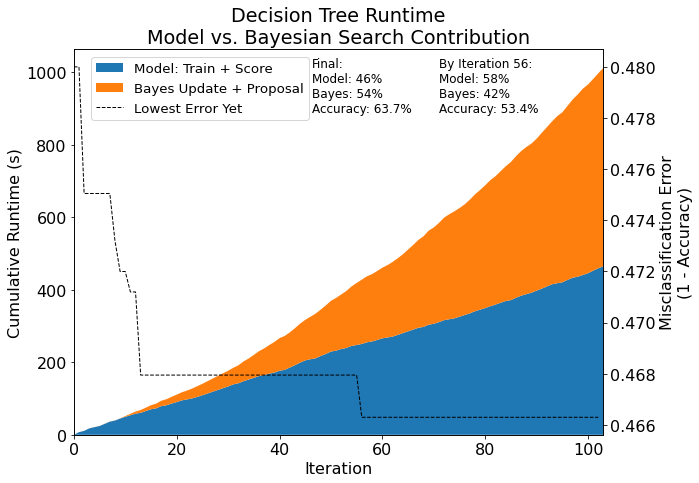

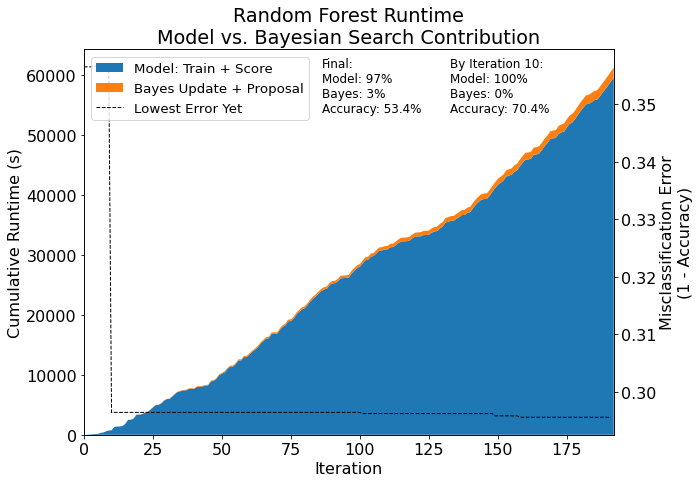

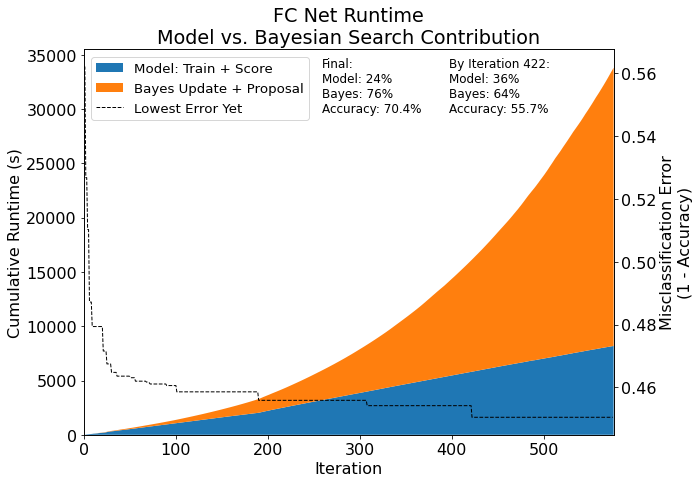

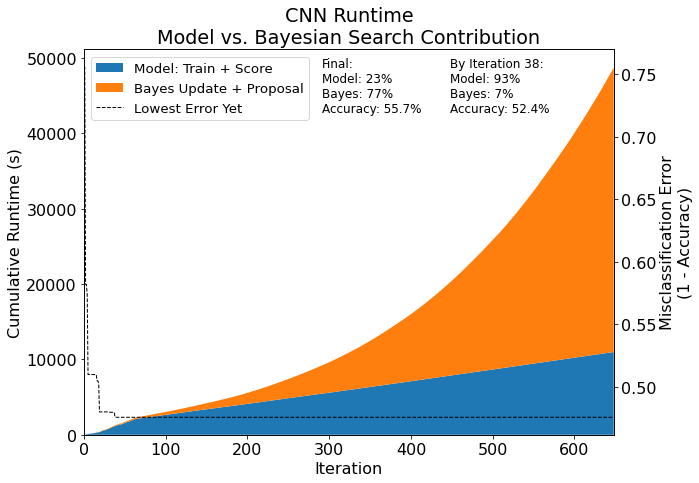

In [86]:
plt.close('all')

# nearbest_iter is based on the above
for bayes_result, timercb, label, nearbest_iter in [(knn_bayes_results, knn_timercb, 'KNN', 24),
                                                   (decisiontree_bayes_results, decisiontree_timercb, 'Decision Tree', 56),
                                                   (randomforest_bayes_results, randomforest_timercb, 'Random Forest', 10),
                                                   (fcnet_bayes_results, fcnet_timercb, 'FC Net', 422),
                                                   (cnn_bayes_results, cnn_timercb, 'CNN', 38)]:

    bayes_result = bayes_result.cv_results_

    accs = np.array(bayes_result['mean_test_score'])
    cumul_accs = np.maximum.accumulate(accs)
    errs = 1-accs
    cumul_errs = 1-cumul_accs

    # note: for KNN, Decision Tree, and Random Forest we multiply by 5 because it's a *mean* fit time, and we did 5-fold CV.
    # for CNN and FC Net, we only did train+test
    multiplier = 1 if label in ['FC Net', 'CNN'] else 5
    
    model_times = np.array(bayes_result['mean_fit_time']) * multiplier + \
                      np.array(bayes_result['mean_score_time']) * multiplier 
    total_times = np.array(timercb.iter_time)
    bayes_times = total_times - model_times

    cumul_totaltime = total_times.cumsum()
    cumul_modeltime = model_times.cumsum()
    cumul_bayestime = bayes_times.cumsum()

    bayes_frac = cumul_bayestime[-1]/cumul_totaltime[-1]
    model_frac = cumul_modeltime[-1]/cumul_totaltime[-1]

    fig, ax1 = plt.subplots(figsize=(10,7))
    plt.rc('font', size=16)

    ax1.stackplot(range(0, len(model_times) + 1), [0, *cumul_modeltime], [0, *cumul_bayestime], 
                labels=['Model: Train + Score', 'Bayes Update + Proposal'])
    plt.xlim((0, len(model_times)))
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Runtime (s)')
    
    plt.annotate('Final:\nModel: {}%\nBayes: {}%\nAccuracy: {}%'.format(round(model_frac * 100), 
                                                                              round(bayes_frac * 100), 
                                                                              round(cumul_acc*100, 1)), 
                (0.45*len(model_times), 0.88*cumul_totaltime[-1]),
                fontsize=12)

    plt.title(f'{label} Runtime\nModel vs. Bayesian Search Contribution')

    if nearbest_iter is not None:
        cumul_acc = cumul_accs[nearbest_iter] if label != 'FC Net' else 0.557
        plt.annotate('By Iteration {}:\nModel: {}%\nBayes: {}%\nAccuracy: {}%'.format(nearbest_iter, 
                                                                                     round(cumul_modeltime[nearbest_iter]/cumul_totaltime[nearbest_iter] * 100), 
                                                                                     round(cumul_bayestime[nearbest_iter]/cumul_totaltime[nearbest_iter] * 100),
                                                                                     round(cumul_acc*100, 1)), 
                    (0.69*len(model_times), 0.88*cumul_totaltime[-1]),
                    fontsize=12)
        ax2 = ax1.twinx()
        ax2.set_ylabel("Misclassification Error\n(1 - Accuracy)")
        ax2.plot(cumul_errs, 'k--', linewidth=1, label="Lowest Error Yet")

    fig.legend(loc=(0.13, 0.75), fontsize='small')
    plt.tight_layout()

# Compare effect of model complexity

In [87]:
import rpy2
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [88]:
%Rpush summary

In [89]:
%%R
library(tidyverse)
df = summary
df = df %>% mutate(search_type = factor(search_type, levels=c("Grid", "Random", "Bayes")),
                   model_type = factor(model_type, levels=c("KNN", "Decision Tree", "Random Forest", "FC Net", "CNN")),
                   nearbest_acc = as.character(paste0(round(nearbest_acc, 3) * 100, "%")))

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [90]:
# set default settings for width, height, and units of %R magic command
## from: https://stackoverflow.com/a/53136954

# save the defaults
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

In [91]:
# change the defaults

# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 4

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

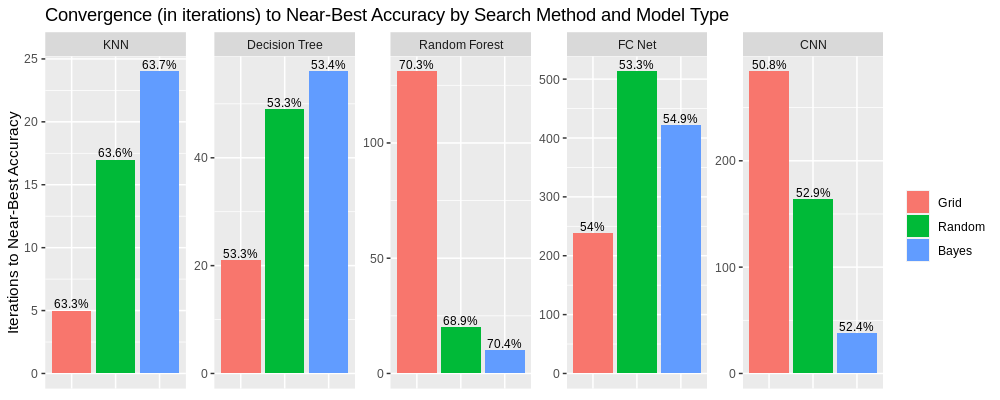

In [92]:
%%R
g1 = ggplot(df) +
    geom_bar(aes(x=search_type, y=nearbest_iter, fill=search_type), stat="identity") +
    geom_text(aes(x=search_type, y=nearbest_iter, label=nearbest_acc), 
              vjust=-.25,
              size=3) +
    facet_wrap(.~model_type, nrow=1, scales="free") +
    ylab("Iterations to Near-Best Accuracy") +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          legend.title = element_blank()) +
    ggtitle("Convergence (in iterations) to Near-Best Accuracy by Search Method and Model Type")

g1

In [93]:
%%R
g1
ggsave("results/complexity_convergence_iterations.png", dpi=100)

R[write to console]: Saving 10 x 4 in image



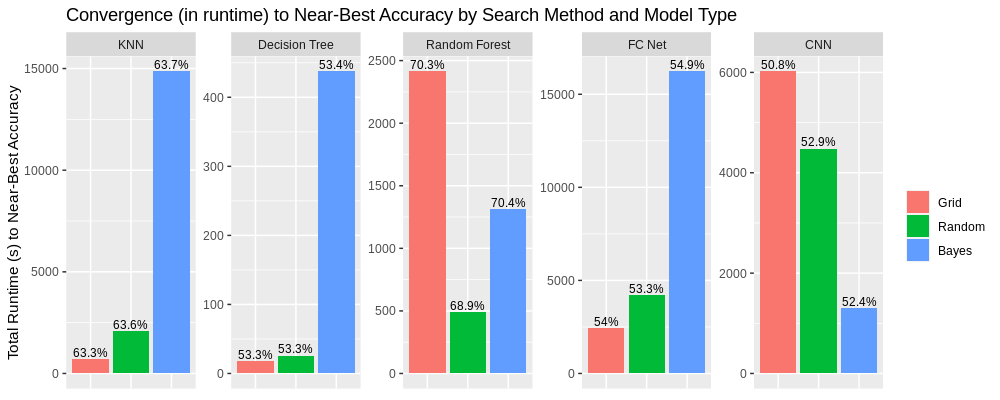

In [94]:
%%R
# Compare the runtimes. Note, this is imperfect.
g2 = ggplot(df) +
    geom_bar(aes(x=search_type, y=nearbest_time, fill=search_type), stat="identity") +
    geom_text(aes(x=search_type, y=nearbest_time, label=nearbest_acc), 
              vjust=-.25,
              size=3) +
    facet_wrap(.~model_type, nrow=1, scales="free") +
    ylab("Total Runtime (s) to Near-Best Accuracy") +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          legend.title = element_blank()) +
    ggtitle("Convergence (in runtime) to Near-Best Accuracy by Search Method and Model Type")
g2

In [95]:
%%R
g2
ggsave("results/complexity_convergence_runtime.png", dpi=100)

R[write to console]: Saving 10 x 4 in image

